In [473]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import cv2
import skimage
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

In [2]:
def range_tuple(mat: np.ndarray):
    return mat.min(), mat.max()

Observatory,SDO
Instrument,AIA 2
Detector,AIA
Measurement,193.0 Angstrom
Wavelength,193.0 Angstrom
Observation Date,2015-12-28 03:16:41
Exposure Time,1.999619 s
Dimension,[256. 256.] pix
Coordinate System,helioprojective
Scale,[9.611424 9.611424] arcsec / pix
Reference Pixel,[127.08625031 127.05374906] pix

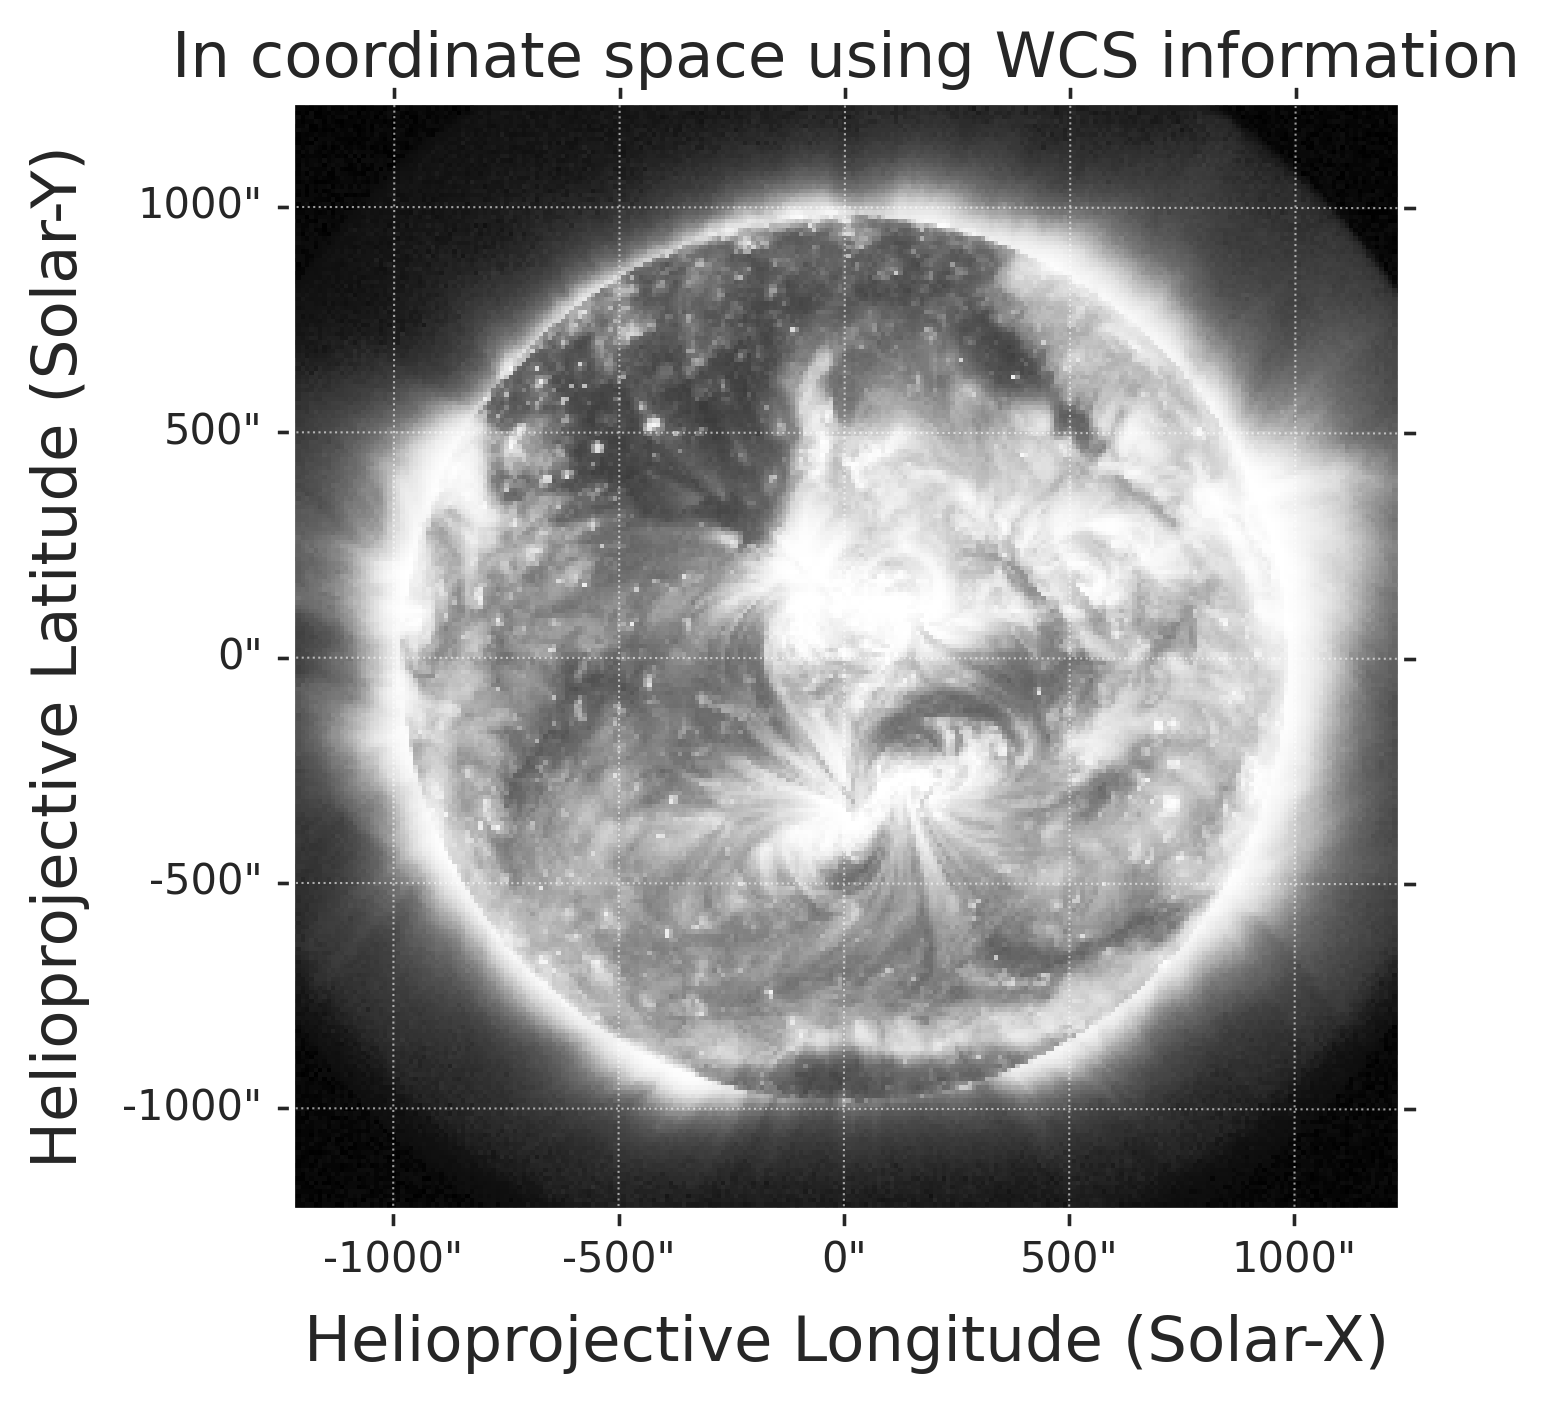
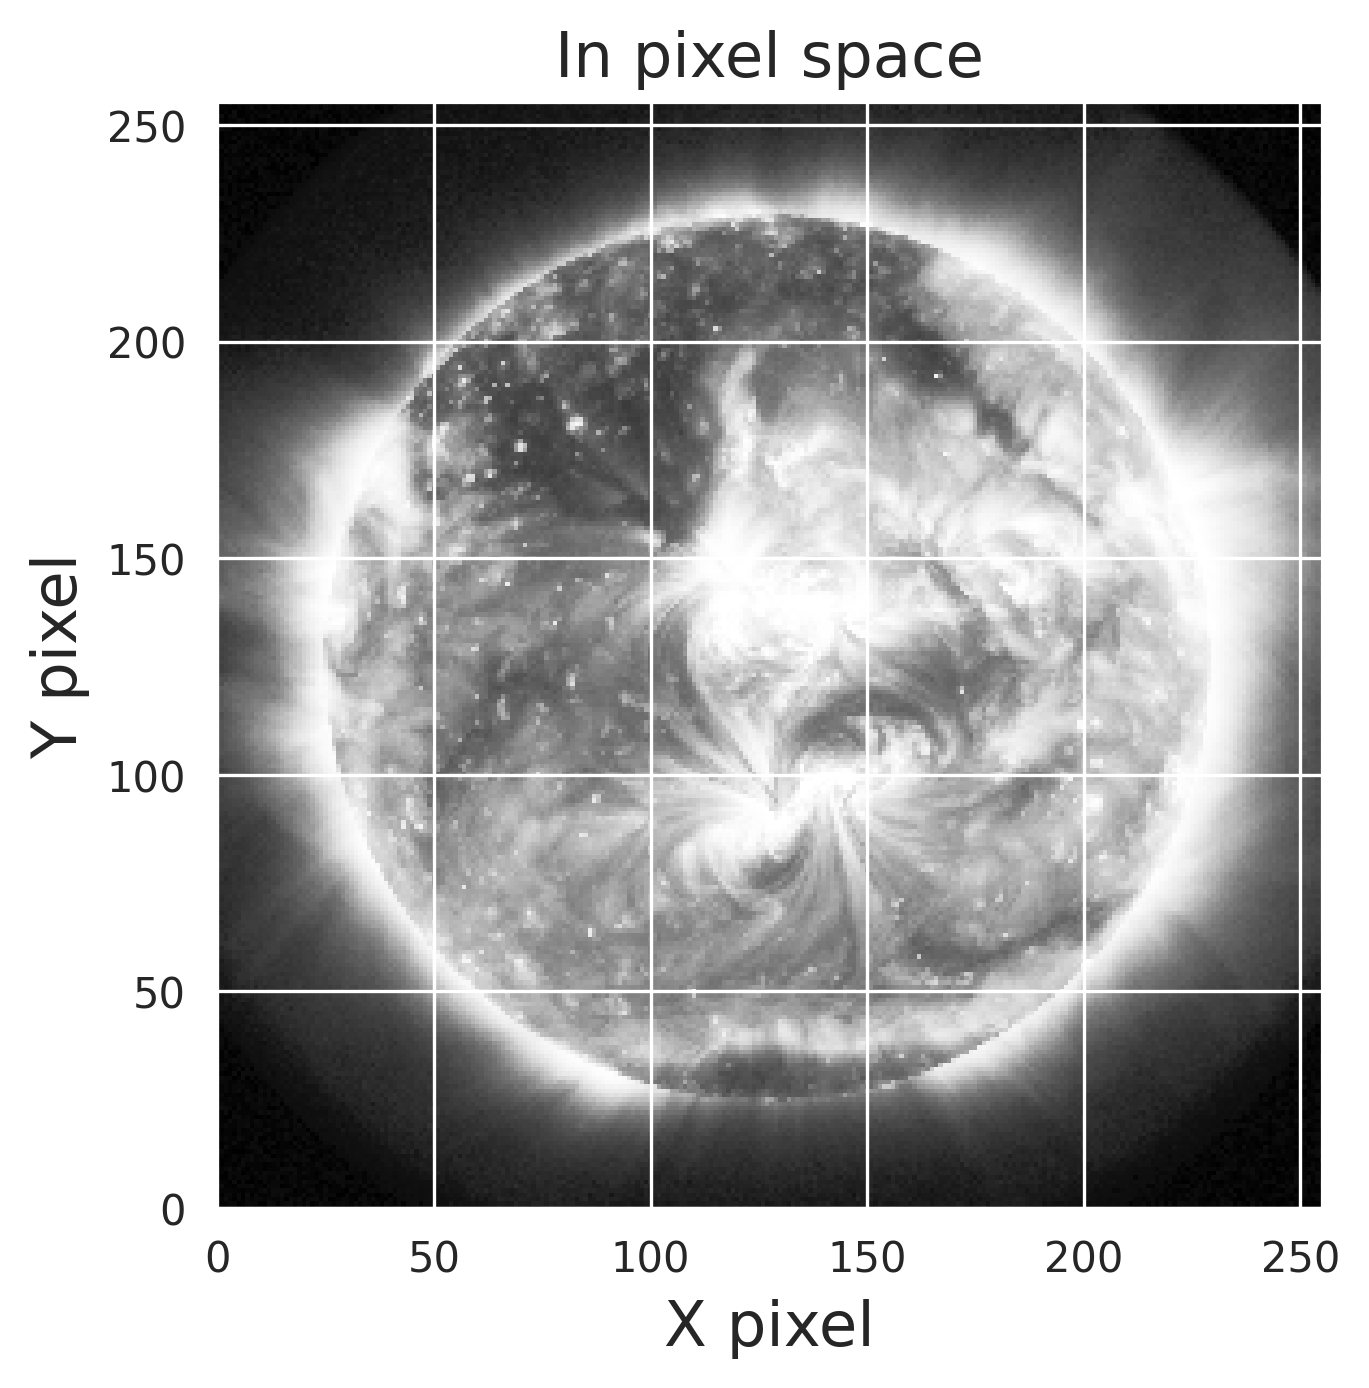
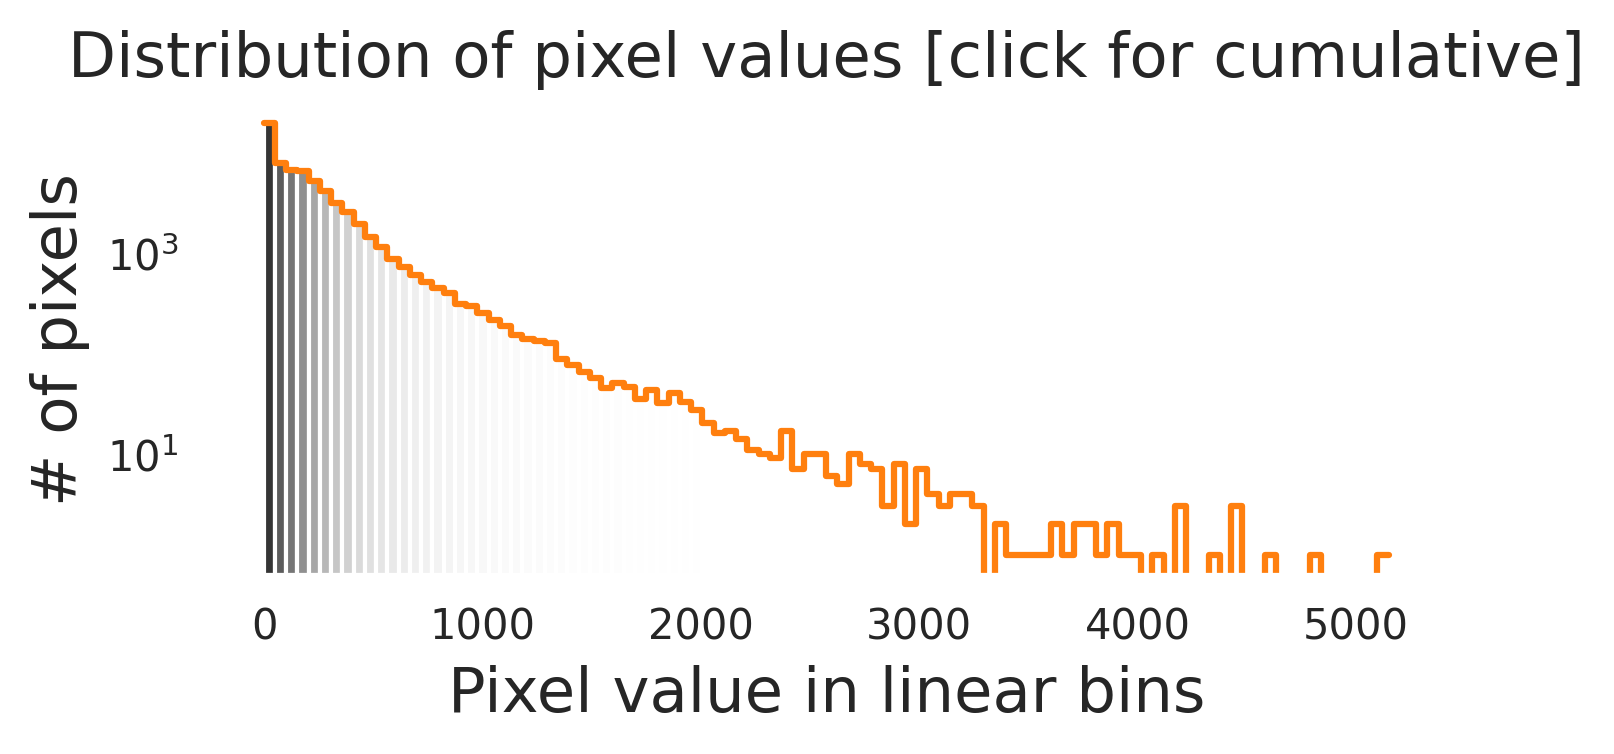
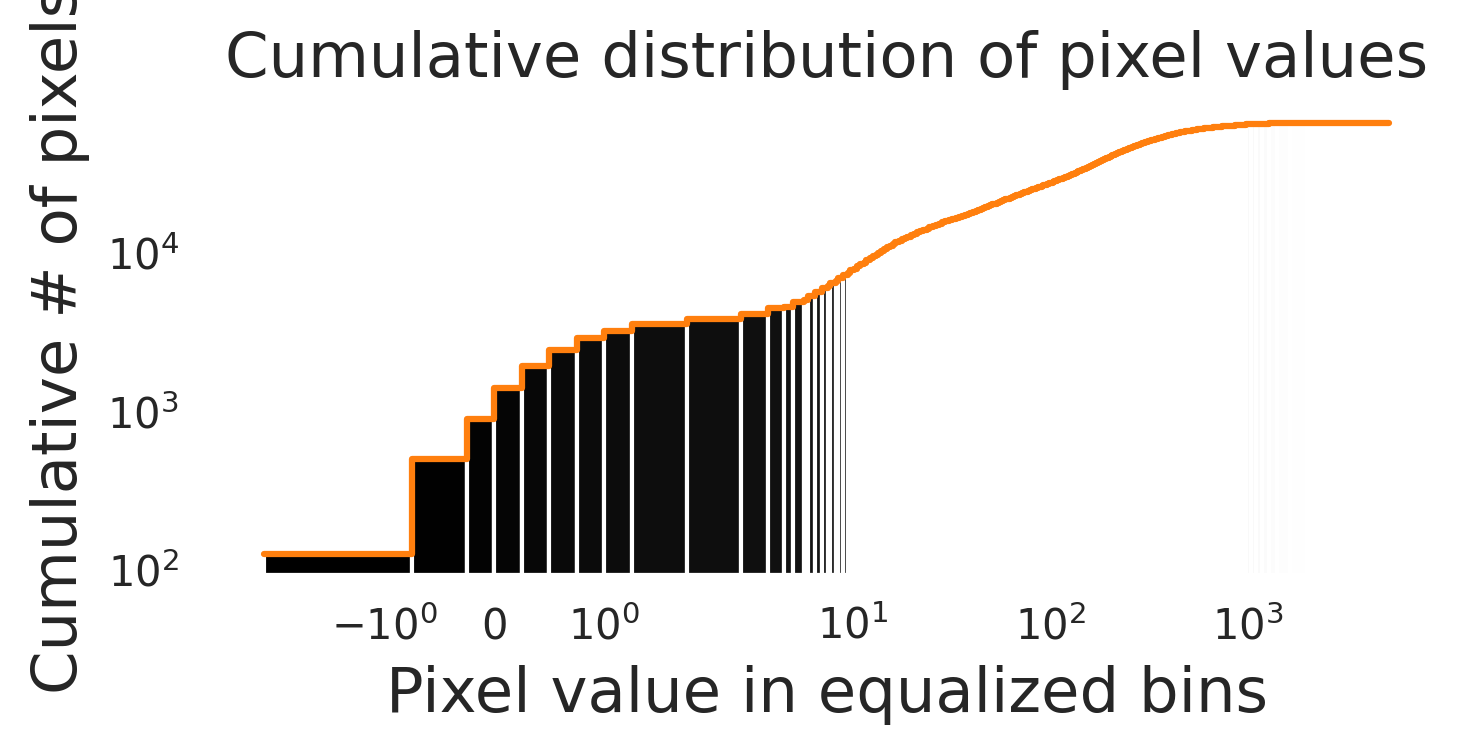

In [3]:
AIA193_2016 = sunpy.map.Map("data/aia_193A/2016*.fits")
AIA193_2016[0]

In [4]:
AIA193_2016_matrix = np.array(list(d.data for d in AIA193_2016))
AIA193_2016_matrix.shape

(2820, 256, 256)

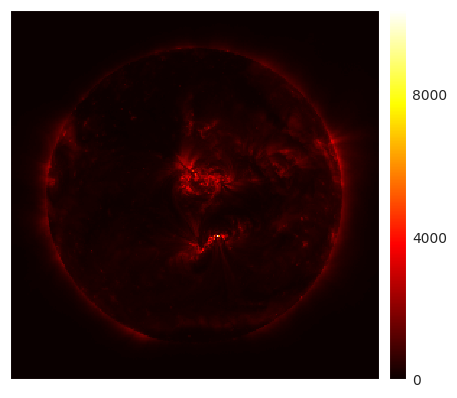

In [5]:
isns.imshow(AIA193_2016_matrix[1], cmap="hot")
plt.show()

In [6]:
print(range_tuple(AIA193_2016_matrix))
print(range_tuple(AIA193_2016_matrix[8]))

(-32768.0, 16383.0)
(-1.75, 6204.0)


In [7]:
min_values = AIA193_2016_matrix.min(axis=2).min(axis=1)
print(min_values.shape)

max_values = AIA193_2016_matrix.max(axis=2).max(axis=1)
max_values.shape

(2820,)


(2820,)

In [71]:
rg = max_values - min_values

rg = np.maximum(rg, 1e-4*np.ones(rg.shape)).reshape([-1,1,1])

AIA193_2016_mnorm = (AIA193_2016_matrix-min_values.reshape([-1,1,1])) / rg
AIA193_2016_mnorm

array([[[6.30822981e-04, 5.82298137e-04, 4.85248447e-04, ...,
         4.85248447e-04, 4.36723602e-04, 4.36723602e-04],
        [3.88198758e-04, 4.36723602e-04, 4.85248447e-04, ...,
         2.91149068e-04, 2.91149068e-04, 5.82298137e-04],
        [5.33773292e-04, 4.36723602e-04, 6.30822981e-04, ...,
         3.39673913e-04, 5.33773292e-04, 6.30822981e-04],
        ...,
        [3.39673913e-04, 3.39673913e-04, 4.85248447e-04, ...,
         5.33773292e-04, 2.91149068e-04, 3.39673913e-04],
        [6.30822981e-04, 4.85248447e-04, 4.85248447e-04, ...,
         3.88198758e-04, 2.91149068e-04, 3.88198758e-04],
        [3.88198758e-04, 2.91149068e-04, 3.88198758e-04, ...,
         4.36723602e-04, 3.88198758e-04, 4.36723602e-04]],

       [[1.92729288e-04, 2.65002770e-04, 1.44546966e-04, ...,
         1.92729288e-04, 1.92729288e-04, 9.63646438e-05],
        [1.44546966e-04, 2.16820449e-04, 1.20455805e-04, ...,
         2.40911610e-04, 2.40911610e-04, 2.40911610e-04],
        [2.89093931e-04, 

In [295]:
AIA193_2016_bytes = np.round(AIA193_2016_mnorm*255).astype(np.uint8)
AIA193_2016_bytes

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       ...,

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0

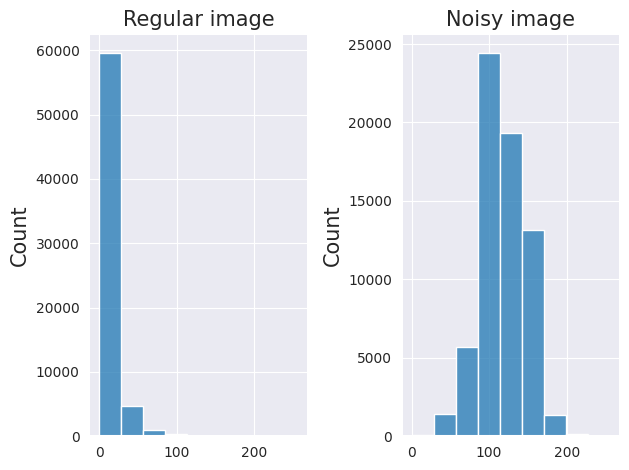

In [489]:
nbins = 10

fig, axes = plt.subplots(1,2)

sns.histplot(AIA193_2016_bytes[0].flatten(), bins=np.linspace(0,256,nbins), ax=axes[0]).set(title="Regular image")

p = sns.histplot(AIA193_2016_bytes[6].flatten(), bins=np.linspace(0,256,nbins), ax=axes[1]).set(title="Noisy image")

fig.tight_layout()

In [ ]:
hist_vectors = np.array([np.histogram(i.flatten(), bins=np.linspace(0,256,nbins))[0] for i in AIA193_2016_bytes])

In [482]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(hist_vectors/hist_vectors.max())
kmeans

KMeans(n_clusters=2)

(2475, 256, 256)
(345, 256, 256)


<AxesSubplot: >

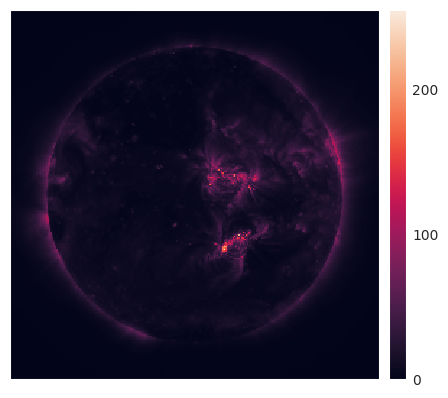

In [484]:
class1 = AIA193_2016_bytes[kmeans.labels_ == 0, :, :]
class2 = AIA193_2016_bytes[kmeans.labels_ != 0, :, :]
print(class1.shape)
print(class2.shape)
isns.imshow(class1[6])